In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Machine_Learning /ed-volume-and-capacity-2021.csv",encoding="ISO-8859-1")

In [4]:
df.head(5)

,oshpd_id,FacilityName2,CountyName,system,LICENSED_BED_SIZE,HospitalOwnership,UrbanRuralDesi,TEACHINGDesignation,Category,Tot_ED_NmbVsts,EDStations,EDDXCount,LATITUDE,LONGITUDE,PrimaryCareShortageArea,MentalHealthShortageArea
0,106010735,Alameda Hospital,Alameda,Alameda Health System,100-149,Government,Urban,Non-Teaching,Active COVID-19,11185,12,262,37.76266,-122.253991,No,No
1,106010735,Alameda Hospital,Alameda,Alameda Health System,100-149,Government,Urban,Non-Teaching,Stroke,11185,12,13,37.76266,-122.253991,No,No
2,106010735,Alameda Hospital,Alameda,Alameda Health System,100-149,Government,Urban,Non-Teaching,COPD,11185,12,318,37.76266,-122.253991,No,No
3,106010735,Alameda Hospital,Alameda,Alameda Health System,100-149,Government,Urban,Non-Teaching,COVID-19 History,11185,12,119,37.76266,-122.253991,No,No
4,106010735,Alameda Hospital,Alameda,Alameda Health System,100-149,Government,Urban,Non-Teaching,Hypertension,11185,12,2856,37.76266,-122.253991,No,No


### Feature Engineering

In [5]:
# Create a ratio of 'Tot_ED_NmbVsts' to 'EDStations' as a measure of capacity utilization
df['ED_Utilization_Ratio'] = df['Tot_ED_NmbVsts'] / df['EDStations']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   oshpd_id                  4265 non-null   int64  
 1   FacilityName2             4265 non-null   object 
 2   CountyName                4265 non-null   object 
 3   system                    2924 non-null   object 
 4   LICENSED_BED_SIZE         4265 non-null   object 
 5   HospitalOwnership         4265 non-null   object 
 6   UrbanRuralDesi            4265 non-null   object 
 7   TEACHINGDesignation       4265 non-null   object 
 8   Category                  4265 non-null   object 
 9   Tot_ED_NmbVsts            4265 non-null   int64  
 10  EDStations                4265 non-null   int64  
 11  EDDXCount                 4265 non-null   int64  
 12  LATITUDE                  4265 non-null   float64
 13  LONGITUDE                 4265 non-null   float64
 14  PrimaryC

In [7]:
# drop the non-important feature columns
# As we use ED_Utilization_Ratio column instead of 'Tot_ED_NmbVsts' column, so we can drop 'Tot_ED_NmbVsts' column.
df = df.drop(['oshpd_id', 'Tot_ED_NmbVsts', 'LATITUDE', 'LONGITUDE', 'EDStations'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FacilityName2             4265 non-null   object 
 1   CountyName                4265 non-null   object 
 2   system                    2924 non-null   object 
 3   LICENSED_BED_SIZE         4265 non-null   object 
 4   HospitalOwnership         4265 non-null   object 
 5   UrbanRuralDesi            4265 non-null   object 
 6   TEACHINGDesignation       4265 non-null   object 
 7   Category                  4265 non-null   object 
 8   EDDXCount                 4265 non-null   int64  
 9   PrimaryCareShortageArea   4265 non-null   object 
 10  MentalHealthShortageArea  4265 non-null   object 
 11  ED_Utilization_Ratio      4265 non-null   float64
dtypes: float64(1), int64(1), object(10)
memory usage: 400.0+ KB


In [9]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Percentage of missing values
missing_percentage = (missing_values / len(df)) * 100

missing_values, missing_percentage

(FacilityName2                  0
 CountyName                     0
 system                      1341
 LICENSED_BED_SIZE              0
 HospitalOwnership              0
 UrbanRuralDesi                 0
 TEACHINGDesignation            0
 Category                       0
 EDDXCount                      0
 PrimaryCareShortageArea        0
 MentalHealthShortageArea       0
 ED_Utilization_Ratio           0
 dtype: int64,
 FacilityName2                0.00000
 CountyName                   0.00000
 system                      31.44197
 LICENSED_BED_SIZE            0.00000
 HospitalOwnership            0.00000
 UrbanRuralDesi               0.00000
 TEACHINGDesignation          0.00000
 Category                     0.00000
 EDDXCount                    0.00000
 PrimaryCareShortageArea      0.00000
 MentalHealthShortageArea     0.00000
 ED_Utilization_Ratio         0.00000
 dtype: float64)

In [10]:
df["system"].unique()

array(['Alameda Health System', 'Sutter Health', nan,
       'Kaiser Foundation Hospitals', 'Dignity Health',
       'John Muir Health', 'Tenet Healthcare Corporation',
       'Adventist Health Systems', 'Providence St. Joseph Health',
       'Alta Hospitals System', 'Prime Healthcare Services',
       'Avanti Hospitals', 'AHMC Healthcare, Inc.',
       'Cedars-Sinai Health System', 'MemorialCare',
       'University of California', 'Verity Health System',
       'University of Southern California', 'HCA Healthcare Corporation',
       'County of Los Angeles', 'Universal Health Services, Inc.',
       'KPC Healthcare, Inc.', 'Sharp Healthcare', 'Scripps Health'],
      dtype=object)

The System columns has approximately 31% missing values, this is __NOT__ good.I am not dropping the missing values,I want to see how important this __System__ feature is in order to predict ED_Utilization_Ratio.Will Impute with zero before progressing.

In [11]:
df.dtypes

FacilityName2                object
CountyName                   object
system                       object
LICENSED_BED_SIZE            object
HospitalOwnership            object
UrbanRuralDesi               object
TEACHINGDesignation          object
Category                     object
EDDXCount                     int64
PrimaryCareShortageArea      object
MentalHealthShortageArea     object
ED_Utilization_Ratio        float64
dtype: object

In [12]:
# categorical columns imputation for system since it's the only column with missing values
for col in df.select_dtypes(include=['object']):
    df[col].fillna(df[col].mode()[0], inplace=True)

In [13]:
missing_values, missing_percentage

(FacilityName2                  0
 CountyName                     0
 system                      1341
 LICENSED_BED_SIZE              0
 HospitalOwnership              0
 UrbanRuralDesi                 0
 TEACHINGDesignation            0
 Category                       0
 EDDXCount                      0
 PrimaryCareShortageArea        0
 MentalHealthShortageArea       0
 ED_Utilization_Ratio           0
 dtype: int64,
 FacilityName2                0.00000
 CountyName                   0.00000
 system                      31.44197
 LICENSED_BED_SIZE            0.00000
 HospitalOwnership            0.00000
 UrbanRuralDesi               0.00000
 TEACHINGDesignation          0.00000
 Category                     0.00000
 EDDXCount                    0.00000
 PrimaryCareShortageArea      0.00000
 MentalHealthShortageArea     0.00000
 ED_Utilization_Ratio         0.00000
 dtype: float64)

In [14]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(df)
numerical_columns_selector = selector(dtype_include=['float64', 'int64'])
numerical_columns = numerical_columns_selector(df)
categorical_columns, numerical_columns


(['FacilityName2',
  'CountyName',
  'system',
  'LICENSED_BED_SIZE',
  'HospitalOwnership',
  'UrbanRuralDesi',
  'TEACHINGDesignation',
  'Category',
  'PrimaryCareShortageArea',
  'MentalHealthShortageArea'],
 ['EDDXCount', 'ED_Utilization_Ratio'])

In [15]:
# education_column = data_categorical[["education"]]
encoder = OrdinalEncoder().set_output(transform="pandas")
encoded_categorical_data = encoder.fit_transform(df[categorical_columns])
encoded_categorical_data

,FacilityName2,CountyName,system,LICENSED_BED_SIZE,HospitalOwnership,UrbanRuralDesi,TEACHINGDesignation,Category,PrimaryCareShortageArea,MentalHealthShortageArea
0,14.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,14.0,0.0,2.0,0.0,0.0,2.0,0.0,15.0,0.0,0.0
2,14.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
3,14.0,0.0,2.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0
4,14.0,0.0,2.0,0.0,0.0,2.0,0.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4260,13.0,51.0,1.0,2.0,2.0,1.0,0.0,8.0,1.0,1.0
4261,13.0,51.0,1.0,2.0,2.0,1.0,0.0,15.0,1.0,1.0
4262,13.0,51.0,1.0,2.0,2.0,1.0,0.0,4.0,1.0,1.0
4263,13.0,51.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0


In [16]:
df = pd.concat([encoded_categorical_data, df[numerical_columns]], axis=1, join='inner')

In [17]:
# select the important feature columns to use the features
X = df.iloc[:,0:11]

In [18]:
X.head(5)

,FacilityName2,CountyName,system,LICENSED_BED_SIZE,HospitalOwnership,UrbanRuralDesi,TEACHINGDesignation,Category,PrimaryCareShortageArea,MentalHealthShortageArea,EDDXCount
0,14.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,262
1,14.0,0.0,2.0,0.0,0.0,2.0,0.0,15.0,0.0,0.0,13
2,14.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,318
3,14.0,0.0,2.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,119
4,14.0,0.0,2.0,0.0,0.0,2.0,0.0,9.0,0.0,0.0,2856


In [19]:
# real output values
y = df['ED_Utilization_Ratio']

In [20]:
y

0        932.083333
1        932.083333
2        932.083333
3        932.083333
4        932.083333
           ...     
4260    1257.750000
4261    1257.750000
4262    1257.750000
4263    1257.750000
4264    1257.750000
Name: ED_Utilization_Ratio, Length: 4265, dtype: float64

In [21]:
# Standarization of data
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[-1.53213369, -1.89154833, -1.93598066, ..., -0.67758198,
        -0.81410566, -0.32580479],
       [-1.53213369, -1.89154833, -1.93598066, ..., -0.67758198,
        -0.81410566, -0.3499452 ],
       [-1.53213369, -1.89154833, -1.93598066, ..., -0.67758198,
        -0.81410566, -0.32037562],
       ...,
       [-1.54593649,  2.0911839 , -2.14910743, ...,  1.47583617,
         1.22834178, -0.31649764],
       [-1.54593649,  2.0911839 , -2.14910743, ...,  1.47583617,
         1.22834178, -0.1193025 ],
       [-1.54593649,  2.0911839 , -2.14910743, ...,  1.47583617,
         1.22834178,  5.01407308]])

In [22]:
#Scaled data has zero mean and unit variance
X_scaled.mean(axis=0)

array([-1.33278825e-17,  5.33115300e-17, -2.66557650e-17,  3.83176622e-17,
       -3.99836475e-17, -2.93213415e-16,  6.66394125e-18,  3.24346516e-17,
        7.99672950e-17,  3.33197062e-17, -1.66598531e-18])

In [23]:
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
# data split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

### Feature Importance

In [25]:
# Standardize the feature variables to improve Lasso performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_train_scaled.shape, y_train.shape

((2985, 11), (2985,))

In [26]:
# Initialize the Lasso regression model with an alpha value that encourages some level of feature selection
lasso = Lasso(alpha=0.01, random_state=42)

# Fit the Lasso model to the training data
lasso.fit(X_train_scaled, y_train)

# Retrieve the feature names and their corresponding coefficients from the Lasso model
feature_names = X.columns
coefficients = lasso.coef_

# Combine feature names and their coefficients in a DataFrame for better visualization
lasso_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Display the coefficients, filtering out those that are zero to see which features are considered important
lasso_coefficients[lasso_coefficients['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
9,MentalHealthShortageArea,101.240354
5,UrbanRuralDesi,69.956884
10,EDDXCount,27.059015
7,Category,2.146098
2,system,-2.848588
1,CountyName,-4.592346
3,LICENSED_BED_SIZE,-6.195129
4,HospitalOwnership,-10.433206
8,PrimaryCareShortageArea,-16.999428
0,FacilityName2,-45.112473


Random Forest Regressor model building and hyper-parameter tuning

In [27]:
# Hyperparameter tuning using RandomizedSearch CV
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['sqrt', 'log2', None] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree

random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth}

In [28]:
# Using the best parameters to train the model
randmf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', max_depth= 80)
randmf.fit( x_train, y_train)

RandomForestRegressor(max_depth=80, max_features='sqrt')

In [29]:
# prediction
y_pred_rf1 = pd.DataFrame( { "actual": y_test,
"predicted_prob": randmf.predict(
( x_test ) ) } )
y_pred_rf1

,actual,predicted_prob
2850,1501.217391,1507.627702
3536,1739.368421,1698.441685
308,1429.625000,1388.290336
1789,1658.333333,1630.246949
4190,1623.500000,1612.420300
...,...,...
1839,1402.500000,1362.028348
3411,1788.714286,1648.528436
3287,707.714286,757.594161
2406,948.869565,985.697369


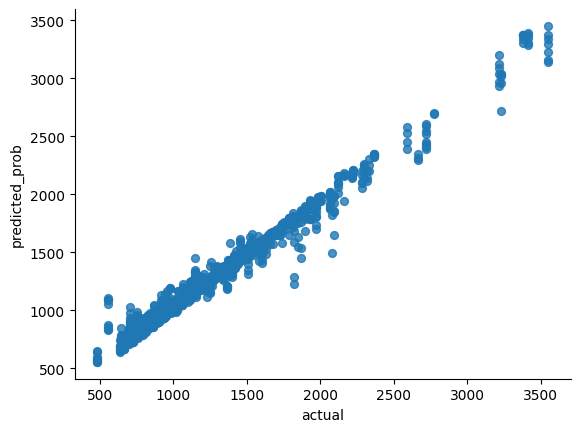

In [30]:
# @title actual vs predicted_prob

from matplotlib import pyplot as plt
y_pred_rf1.plot(kind='scatter', x='actual', y='predicted_prob', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
# model evaluation
mse = mean_squared_error(y_pred_rf1['actual'], y_pred_rf1['predicted_prob'])
rmse = np.sqrt(mse)
rmse

93.73355254087971

In [32]:
R2_score = r2_score(y_pred_rf1['actual'], y_pred_rf1['predicted_prob'])
R2_score

0.9692387137608075

In [33]:
# Mean squared log error
RMSLE = np.sqrt( mean_squared_log_error(y_pred_rf1['actual'], y_pred_rf1['predicted_prob']) )
print("The RMSLE score is %.5f" % RMSLE)

The RMSLE score is 0.08187


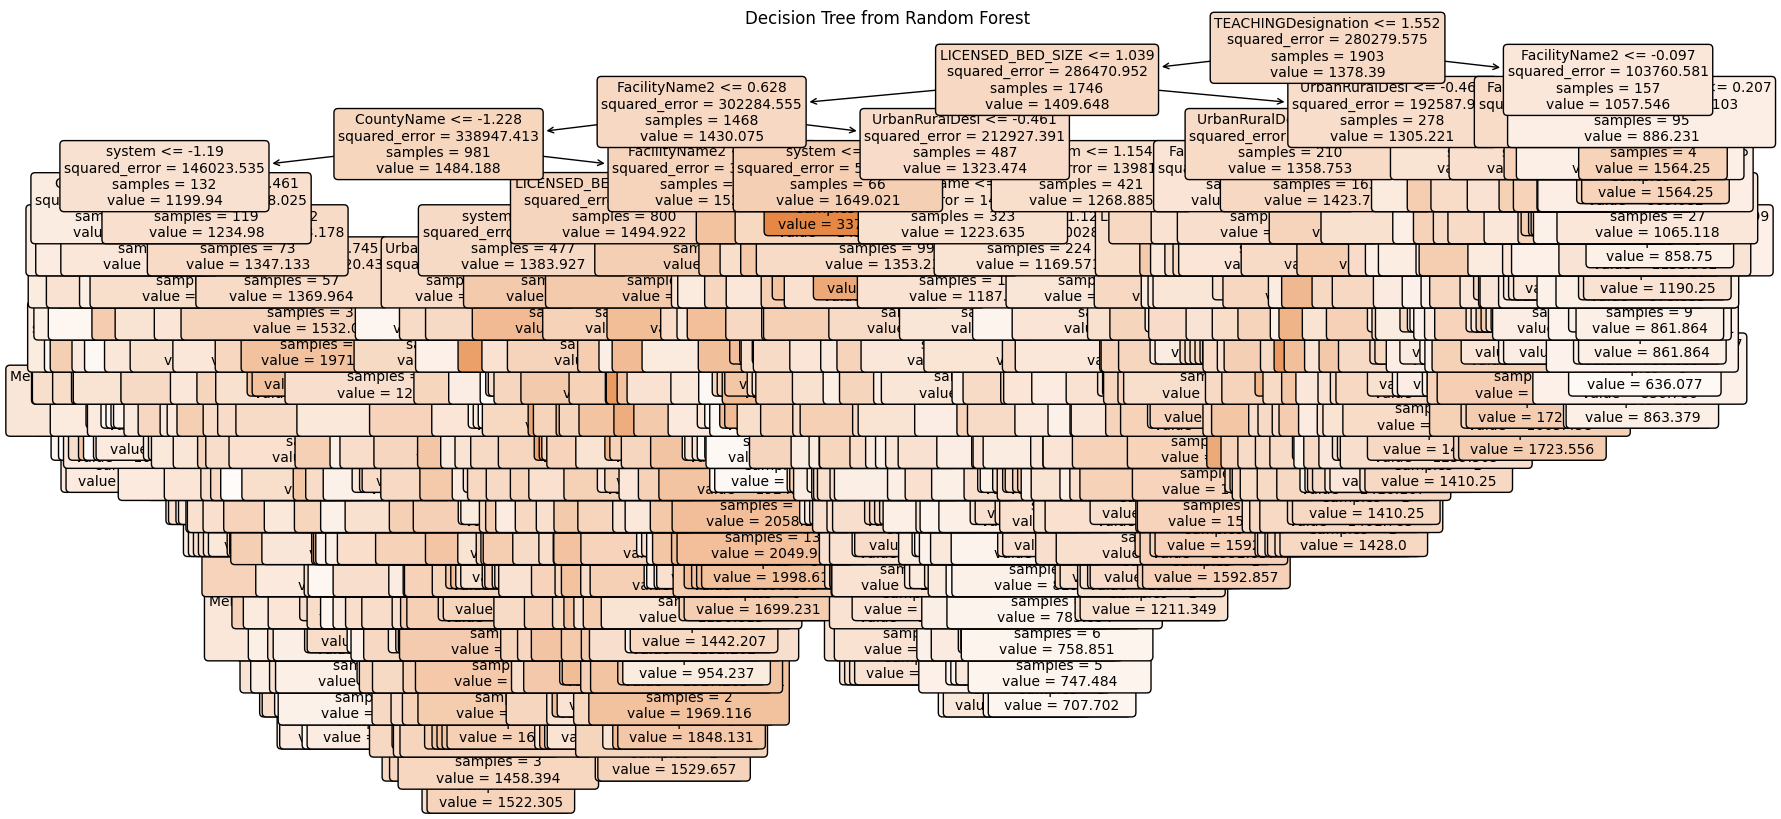

In [34]:
# Assuming RandomForestRegModel is the trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = randmf.estimators_[0]
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

XGBoost model building and hyper-parameter tuning

In [35]:
# data preparation has been already done, so we can use preprocessed data itself for XGboost regression.
# We will consider only 3 hyper-parameters.
# XGBoost regression:
# Parameters:
# n_estimators  "Number of gradient boosted trees. Equivalent to number
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make
#                the model more complex and more likely to overfit."

regressor=xgb.XGBRegressor(eval_metric='rmsle')

# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(x_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 700}


In [36]:
# we will now use these values for our hyperparameters in our final calculation

regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
# use the model to predict the prices for the test data

y_pred_2 = pd.DataFrame( { "actual": y_test,
"predicted_prob": regressor.predict(
( x_test ) ) } )
y_pred_2

,actual,predicted_prob
2850,1501.217391,1507.839722
3536,1739.368421,1704.952515
308,1429.625000,1384.974365
1789,1658.333333,1623.307739
4190,1623.500000,1618.738281
...,...,...
1839,1402.500000,1443.328613
3411,1788.714286,1693.485229
3287,707.714286,800.246643
2406,948.869565,1190.796387


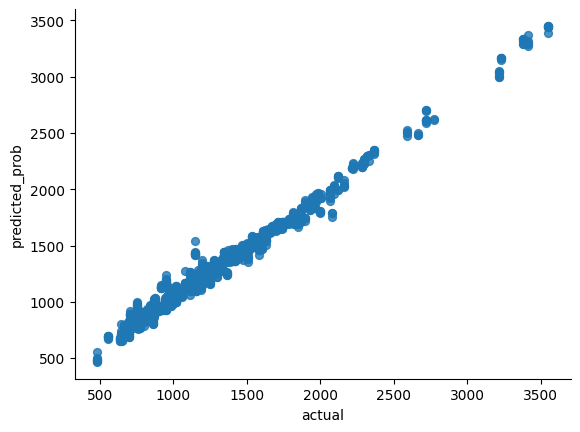

In [38]:
# @title actual vs predicted_prob

from matplotlib import pyplot as plt
y_pred_2.plot(kind='scatter', x='actual', y='predicted_prob', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
# model evaluation
mse_xgb = mean_squared_error(y_pred_2['actual'], y_pred_2['predicted_prob'])
rmse_xgb = np.sqrt(mse_xgb)
rmse_xgb

81.01572005385258

In [40]:
R2_score_xgb = r2_score(y_pred_2['actual'], y_pred_2['predicted_prob'])
R2_score_xgb

0.9770198463084868

In [41]:
# Mean squared log error
RMSLE_xgb = np.sqrt( mean_squared_log_error(y_pred_2['actual'], y_pred_2['predicted_prob']) )
print("The RMSLE score is %.5f" % RMSLE_xgb )

The RMSLE score is 0.07194


Overall, We used random search and grid search for random forest regressor and XGBoost model respectively to select best hyper-parameters. Based on the model evaluation metrics, we can compare the capabilities of two models.__RMLSE__ penalizes the underestimation of the actual value more severely than it does for the Overestimation.



XGBoost Model: The RMSLE score is 0.07194
RandomForest Model: The RMSLE score is 0.08187
The RMSLE metric is particularly useful when you want to penalize underestimations more than overestimations, and when the magnitude of the error is more important than the direction of the error.

In comparing the two scores:

A __lower RMSLE__ value indicates a better fit of the model to the data.
The XGBoost model has a __lower RMSLE (0.07194)__ compared to the RandomForest model (0.08187).
Therefore, based on the RMSLE metric alone, the XGBoost model is performing better than the RandomForest model. It's making predictions closer to the actual values when both underestimations and overestimations are taken into account logarithmically.

However, it's important to consider other performance metrics as well before finalizing the best model, such as R-squared, Mean Absolute Error, and the context of the problem. RMSLE is just one aspect of model performance, and different metrics may prioritize different aspects of the prediction errors.